# Solving the CVRP(capacitated vehicle routing problem) using genetic algorithm



VRP(vehicle routing problem) is one of well-known optimization problems, whose aim is to find optimal routes for a group of vehicles to complete delivery to customers based on certain constraints. In VRP, the target of optimization can be defined in various ways according to the purpose, such as the number of vehicles, total distance to deliver, delivery time and delivery cost. VRP is also an generalized version of TSP(Travelling salesman problem).

Here, we are looking for how to obtain a solution of VRP, using genetic algorithm. Genetic algorithm is one of metaheuristic methods, which is designed to solve optimization problem. The approach of genetic algorithm is that constructs an initial solution set consisting of chromosomes, creates a solution set of a next generation through selection, crossover, mutation of chromosomes, and repeat this generational process until a certain condition is satisfied.  
See https://en.wikipedia.org/wiki/Genetic_algorithm for more detail.

There are a lot of variants of VRP.

- Capacitated vehicle routing problem (CVRP): the case when the vehicle's carrying capacity is limited
- Vehicle Routing Problem with Time Windows (VRPTW): the case when all deliveries must be done within certain time indows
- Vehicle Routing Problem with Profits (VRPP): the case when the aim is to maximize profits. Vehicles do not need to visit all customers.
- Multi-Depot Vehicle Routing Problem (MDVRP): the case when there are multiple depots for vehicles to depart and arrive

Among these variants, we are going to solve Capacitated vehicle routing problem (CVRP).

# Problem Setting

Consider that we have 3 vehicles and 8 customers(locations). Our goal is to find the shortest routes to visit all customers. To simplify the problem, we consider straight-line distance between customers, not real road distances. More specifically, we have conditions as follows:

- There is one depot (the point at which vehicles depart, visit customers and return).
- There are 8 customers(locations) to visit.
- Exactly 1 item has to be shipped for each location.
- The number of vehicles is 3.
- All vehicles' volume capacity are 3. 
- Goal: Minimize the total (straight-line) distance of delivery routes.

# Genetic Algorithm Design

1. Chromosome representation for routes

When the genetic algorithm is applied to VRP, each chromosome expresses a feasible route, and the population becomes a set of feasible routes. We represent a chromosome as a permutation of an integer from 1 to 8 because we have to visit 8 customers. Also, we express seperated routes for 3 vechicles by inserting 0 which represents the depot.

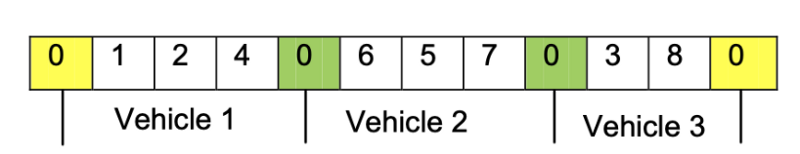<center>*Fig. 1. An example of chromosome (see Y. Zhang, X.D. Chen, An Optimization Model for the Vehicle Routing Problem in Multi-product Frozen Food Delivery)*

2. Fitness

Fitness is an evaluation metric for chromosomes which is a value to optimize in the problem. Defining the fitness function is very important in genetic algorithms, and the results can vary greatly depending on how you define fitness. Here, the fitness for a route is defined as the sum of the straight-line distances between customers plus penelties. That is, basically the fitness is the total distance, and if the route exceeds the capacity of each vehicle (when more than 3 routes are assigned to a vehicle), 5000 is added to the fitness as a penelty each time the capacity is exceeded.  Our purpose is to minimize the fitness.

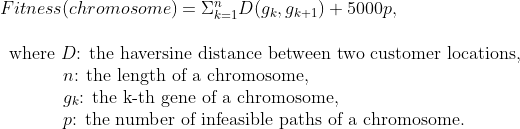<center>*Fig.2. The fitness formula for each chromosome*

3. Selection

Selection is an operation that calculates fitness for all chromosomes in a population and then selects excellent chromosomes in terms of fitness. Various selection operators are being studied, but we will use tournament selection. Tournament selection randomly selects two chromosomes from the entire population, selects the chromosome with lower fitness among the two as the winner, and sends it to the next generation.

4. Crossover

Next, we apply crossover the winner chromosomes. Crossover is used to generate new offspring by exchanging genes from two superior parents selected by a selection operation. Here, offspring is created through simple crossover by exchanging genes between parents with one crossover position.

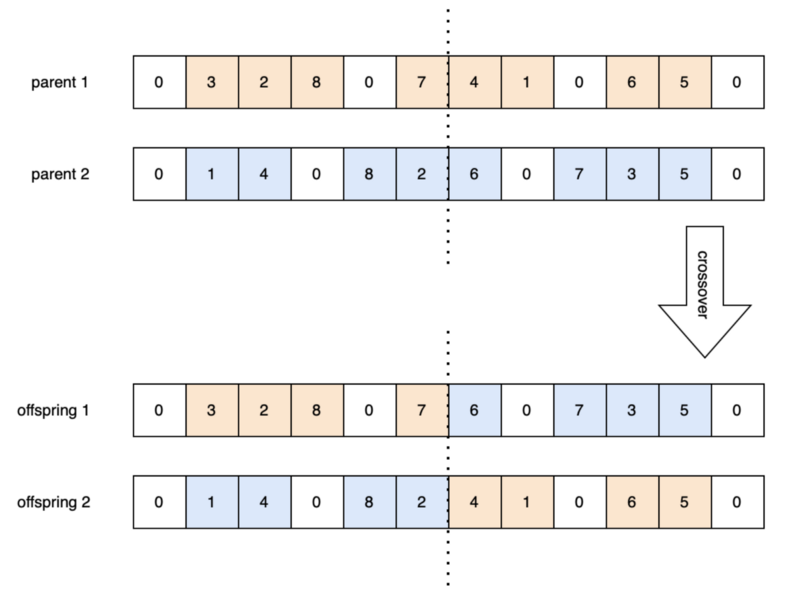<center>*Fig.3. An example of the crossover operation*

5. Repair

In genetic algorithm for VRP, a simple crossover does not produce proper offsprings. When you see Fig.3, you can see that customers 3 and 7 are duplicated in offspring 1, and customers 1 and 4 are duplicated in offspring 2, creating an infeasible route. To resolve these duplications, an operation called repair is required. The repair process is as follows. Replace duplicate numbers 3, 7 in offspring 1 with duplicate 1, 4 in offspring 2.

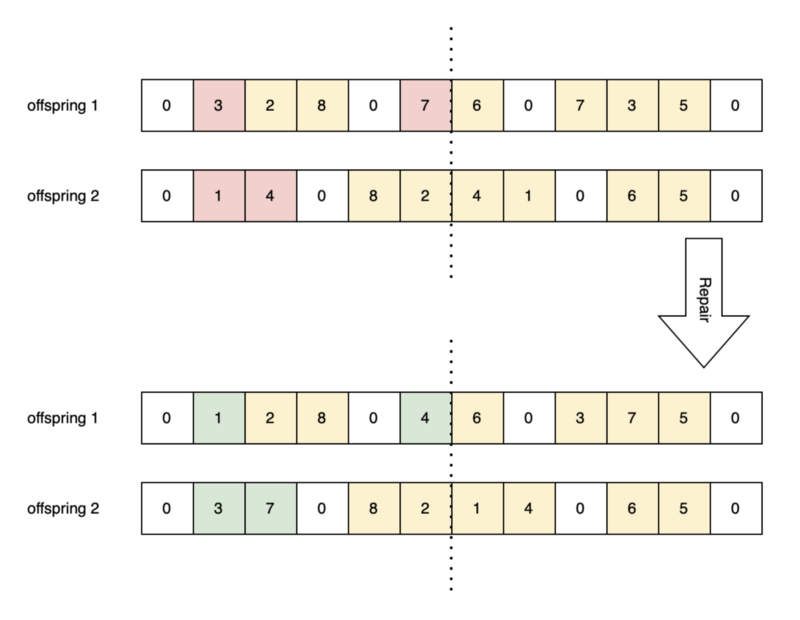<center>*Fig.4. Repair process*

6. Mutation

As above, if selection and crossover are repeated, the population becomes more and more similar to each other as generations pass, and the genetic algorithm reaches the local optimum and stops learning. However, since we want to find a solution that is as close to the global optimum as possible, we generate mutations with a certain probability in the generated offspring to escape from the local optimum. You can imagine that mutations occur during evolution to maintain genetic diversity. The mutation operation we will use is an inverse mutation as follows. Randomly select two intersections and arrange the numbers in the middle in reverse order.

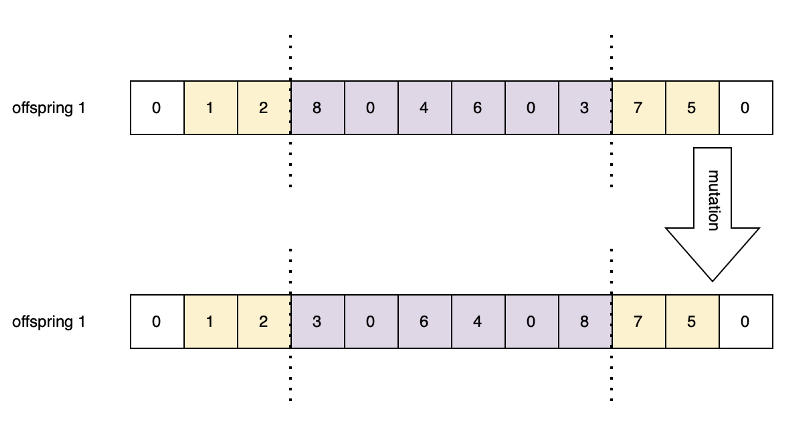<center>*Fig.5. An example of the inverse mutation*

The python code for above algorithm design is as follows.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import random
from random import randrange
from time import time 
from haversine import haversine
from functools import reduce


"""

Genetic Algorithm Operations
original source code: https://github.com/fermenreq/TSP-VRP-GENETICS-ALGORITHM
author: José Luis González Chacón, Fernando Méndez Requena

modified by Belina Kim

"""


class Problem_Genetic(object):
    
    def __init__(self,genes,individuals_length,decode,fitness):
        self.genes= genes # list of (location, loads)
        self.individuals_length= individuals_length # (cities(location) 개수) + (vehicles 개수 - 1)
        self.decode= decode 
        self.fitness= fitness

    def mutation(self, chromosome, prob):
            
            def inversion_mutation(chromosome_aux):
                chromosome = chromosome_aux
                
                index1 = randrange(0,len(chromosome))
                index2 = randrange(index1,len(chromosome))
                
                chromosome_mid = chromosome[index1:index2]
                chromosome_mid.reverse()
                
                chromosome_result = chromosome[0:index1] + chromosome_mid + chromosome[index2:]
                
                return chromosome_result
        
            aux = chromosome
#             for _ in range(len(chromosome)):
            if random.random() < prob :
                aux = inversion_mutation(chromosome)
            return aux

    def crossover(self,parent1, parent2):

        def process_gen_repeated(copy_child1,copy_child2):
            count1=0
            for gen1 in copy_child1[:pos]:
                repeat = 0
                repeat = copy_child1.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent1[pos:]:#Choose next available gen
                        if gen2 not in copy_child1:
                            child1[count1] = parent1[pos:][count2]
                        count2+=1
                count1+=1

            count1=0
            for gen1 in copy_child2[:pos]:
                repeat = 0
                repeat = copy_child2.count(gen1)
                if repeat > 1:#If need to fix repeated gen
                    count2=0
                    for gen2 in parent2[pos:]:#Choose next available gen
                        if gen2 not in copy_child2:
                            child2[count1] = parent2[pos:][count2]
                        count2+=1
                count1+=1

            return [child1,child2]

        pos=random.randrange(1,self.individuals_length-1)
        child1 = parent1[:pos] + parent2[pos:] 
        child2 = parent2[:pos] + parent1[pos:] 
        
        return  process_gen_repeated(child1, child2)

def decodeVRP(chromosome):    
    chromosome = [cars_info[0]] + chromosome
    return chromosome

def penalty_demand(chromosome):
    routes = [] # chromosome를 route로 분리
    sublist = []
    cars_by_route = [cars_info[0]] # 각 route에 대응되는 car저장
    for x in chromosome:
        if x in cars_info:
            cars_by_route.append(x)
            routes.append(sublist)
            sublist = []
        else:
            sublist.append(x)
    routes.append(sublist)

    overloads = 0
    for i in range(len(routes)):
        capa = cars_by_route[i][1] 
        volume = sum([x[1] for x in routes[i]])
        if volume > capa:
            overloads += (volume - capa)
        
    return overloads

def penalty_spot(chromosome):
    routes = [] # chromosome를 route로 분리
    sublist = []
    cars_by_route = [cars_info[0]] # 각 route에 대응되는 car저장
    for x in chromosome:
        if x in cars_info:
            cars_by_route.append(x)
            routes.append(sublist)
            sublist = []
        else:
            sublist.append(x)
    routes.append(sublist)

    overloads = 0
    for i in range(len(routes)):
        capa = cars_by_route[i][2] 
        volume = sum([x[2] for x in routes[i]])
        if volume > capa:
            overloads += (volume - capa)
        
    return overloads

    
def dist_bw_genes(gene0, gene1):
    
    center = spot_coord['center']
    
    if type(gene0) != int:
        if type(gene1) == int:
            x1, y1 = spot_coord[gene1]
            return haversine(center, (x1, y1), unit='km')
        else:
            return 0
        
    else:
        x0, y0 = spot_coord[gene0]
        if type(gene1) == int:
            x1, y1 = spot_coord[gene1]
            return haversine((x0, y0), (x1, y1), unit='km')
        else:
            return haversine(center, (x0, y0), unit='km')

def fitness_by_dist(chromosome):
    _chromosome = [cars_info[0]] + chromosome +  [cars_info[0]]
    d = 0
    for i in range(len(_chromosome)-1):
        d += dist_bw_genes(_chromosome[i][0], _chromosome[i+1][0])
    
#     penalty1 = penalty_demand(chromosome)
    penalty2 = penalty_spot(chromosome)
#     return d + (100 * penalty1) + (5000 * penalty2)
    return d + (5000 * penalty2)

"""

Genetic Algorithm
original source code: https://github.com/fermenreq/TSP-VRP-GENETICS-ALGORITHM
author: José Luis González Chacón, Fernando Méndez Requena

modified by Belina Kim

"""

def genetic_algorithm_t(Problem_Genetic,k,opt,ngen,size,ratio_cross,prob_mutate):
    
    def initial_population(Problem_Genetic,size):   
        def generate_chromosome():
            chromosome=[]
            for i in Problem_Genetic.genes:
                chromosome.append(i)
            random.shuffle(chromosome)
            return chromosome
        return [generate_chromosome() for _ in range(size)]
            
    def new_generation_t(Problem_Genetic,k,opt,population,n_parents,n_directs,prob_mutate):
        
        def tournament_selection(Problem_Genetic,population,n,k,opt):
            winners=[]
            for _ in range(n):
                elements = random.sample(population,k)
                winners.append(opt(elements,key=Problem_Genetic.fitness))
            return winners
        
        def cross_parents(Problem_Genetic,parents):
            childs=[]
            for i in range(0,len(parents),2):
                childs.extend(Problem_Genetic.crossover(parents[i],parents[i+1]))
            return childs
    
        def mutate(Problem_Genetic,population,prob):
            new_population = []
            for i in population:
                new_population.append(Problem_Genetic.mutation(i,prob))
            return new_population
                        
        directs = tournament_selection(Problem_Genetic, population, n_directs, k, opt)
        crosses = cross_parents(Problem_Genetic,
                                tournament_selection(Problem_Genetic, population, n_parents, k, opt))
        mutations = mutate(Problem_Genetic, crosses, prob_mutate)
        new_generation = directs + mutations
        
        return new_generation
    
    population = initial_population(Problem_Genetic, size)
    n_parents = round(size*ratio_cross)
    n_parents = (n_parents if n_parents%2==0 else n_parents-1)
    n_directs = size - n_parents 
    
    best_solns = []
    
    for _ in range(ngen):
        population = new_generation_t(Problem_Genetic, k, opt, population, n_parents, n_directs, prob_mutate)
        best_sol = opt(population, key = Problem_Genetic.fitness)
        best_solns.append(best_sol)
        
    bestChromosome = opt(population, key = Problem_Genetic.fitness)
    genotype = Problem_Genetic.decode(bestChromosome)
    print ("Solution: " , genotype)
    print('fitness:', Problem_Genetic.fitness(bestChromosome))
    scores = [Problem_Genetic.fitness(sol) for sol in best_solns]
    plt.figure(figsize=(10,7))
    plt.plot(np.arange(ngen), scores)
    plt.show()
    return (genotype, Problem_Genetic.fitness(bestChromosome))

# Experiment

Now it's time to solve the VRP by applying the genetic algorithm. Let us assume that 3 vehicles have to visit the following 8 locations in Seocho-dong, Seoul.

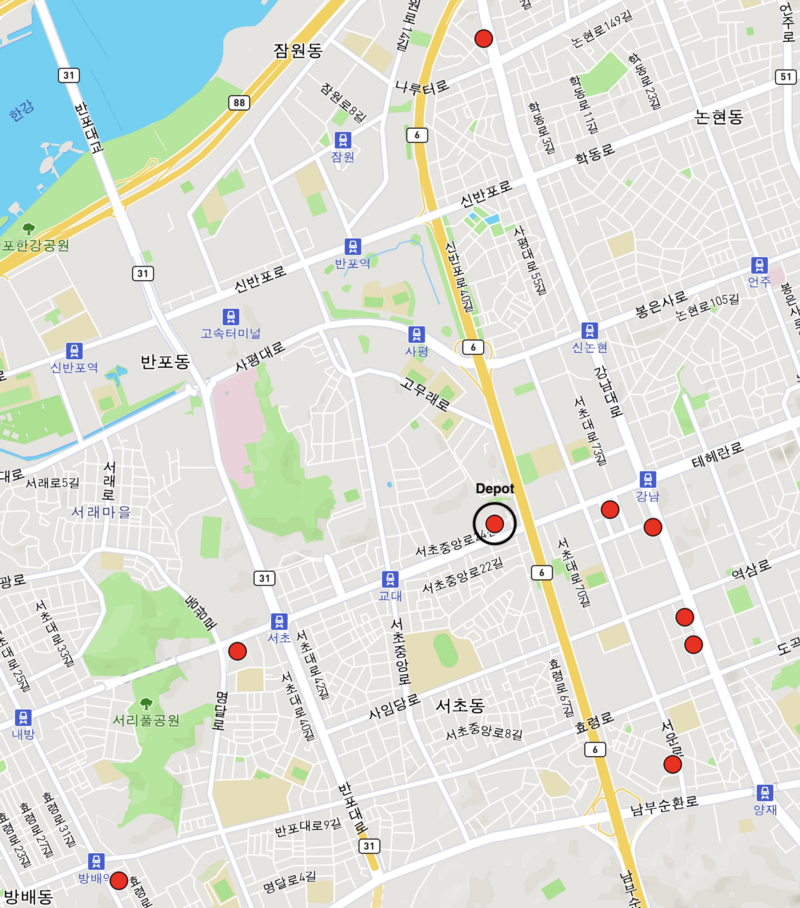<center>*Fig.6. 8 locations to visit and 1 depot in Seocho-dong*

In Fig. 6, There are 9 red points including the depot, which is inside the black circle. The latitude and longitude of 8 locations and 1 depot are as follows.

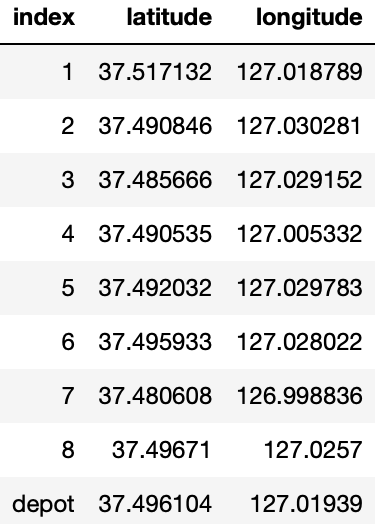

Now we apply the genetic algorithm we designed. The parameters for this experiment are:

- population size = 100
- generation number = 100
- crossover rate = 0.8
- mutation rate = 0.1

The python code for the experiment is as follows.

EXECUTING  10  INSTANCES 
Frontier =  ---------

Solution:  [('car1', 3, 3), (7, 1, 1), (4, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (1, 1, 1), (6, 1, 1), (8, 1, 1)]
fitness: 13.93888798797761


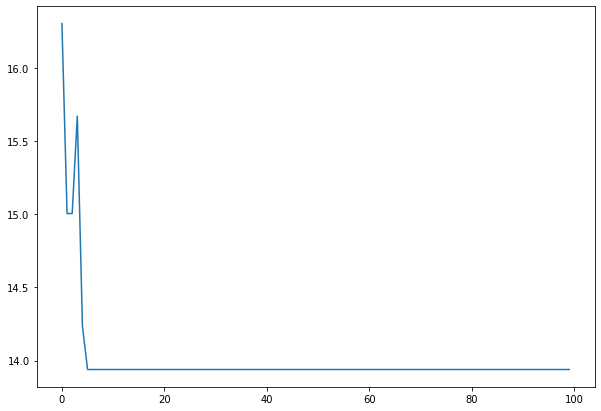

Solution:  [('car1', 3, 3), (7, 1, 1), (4, 1, 1), ('car2', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car3', 3, 3), (8, 1, 1), (6, 1, 1), (1, 1, 1)]
fitness: 13.93888798797761


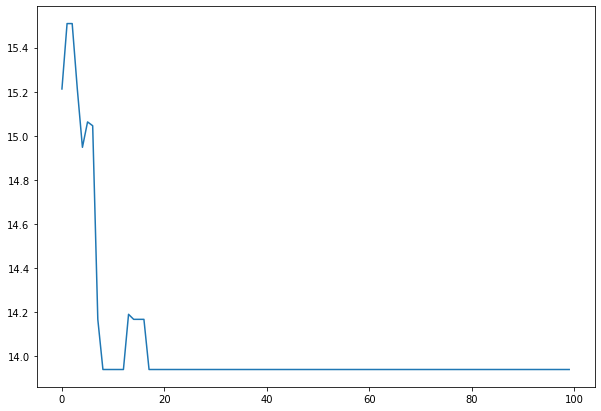

Solution:  [('car1', 3, 3), (4, 1, 1), (7, 1, 1), ('car2', 3, 3), (8, 1, 1), (6, 1, 1), (1, 1, 1), ('car3', 3, 3), (3, 1, 1), (5, 1, 1), (2, 1, 1)]
fitness: 14.166540611733003


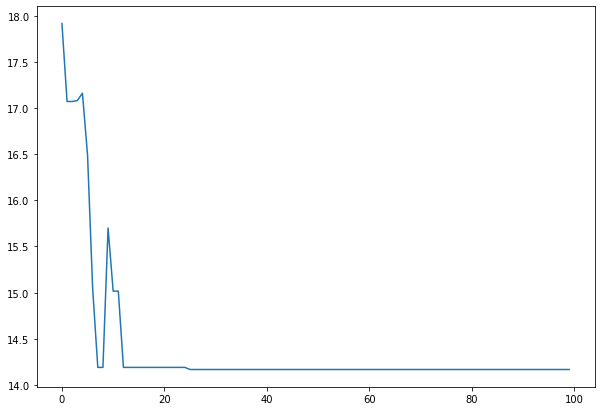

Solution:  [('car1', 3, 3), (4, 1, 1), (7, 1, 1), ('car2', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car3', 3, 3), (8, 1, 1), (6, 1, 1), (1, 1, 1)]
fitness: 13.93888798797761


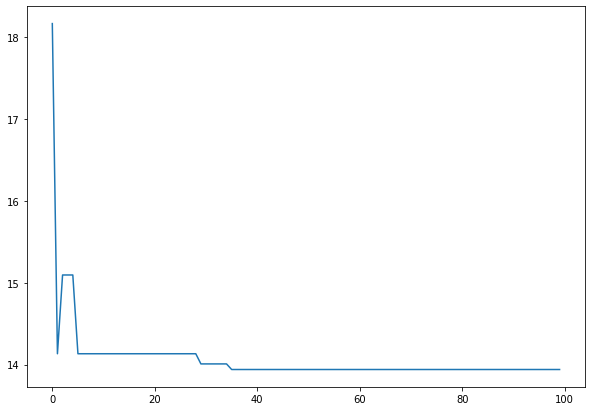

Solution:  [('car1', 3, 3), (4, 1, 1), (7, 1, 1), ('car3', 3, 3), (5, 1, 1), (2, 1, 1), (3, 1, 1), ('car2', 3, 3), (1, 1, 1), (6, 1, 1), (8, 1, 1)]
fitness: 13.93888798797761


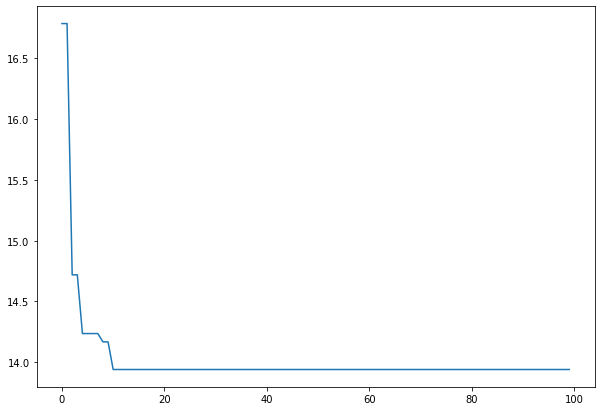

Solution:  [('car1', 3, 3), (4, 1, 1), (7, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (1, 1, 1), (8, 1, 1), (6, 1, 1)]
fitness: 13.997188689363679


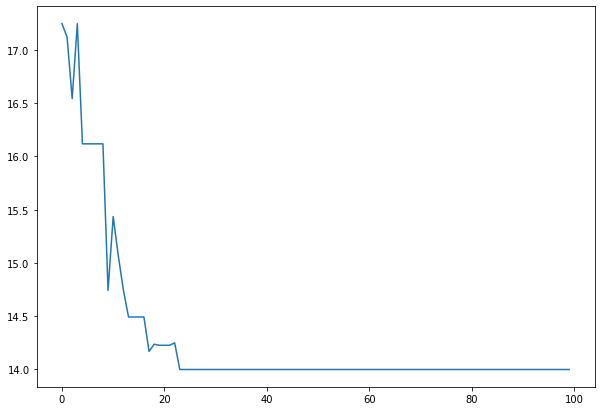

Solution:  [('car1', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car3', 3, 3), (1, 1, 1), (6, 1, 1), (8, 1, 1), ('car2', 3, 3), (4, 1, 1), (7, 1, 1)]
fitness: 13.938887987977612


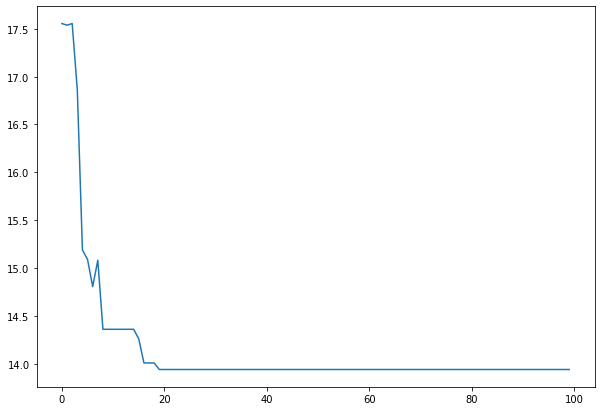

Solution:  [('car1', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car3', 3, 3), (8, 1, 1), (6, 1, 1), (1, 1, 1), ('car2', 3, 3), (7, 1, 1), (4, 1, 1)]
fitness: 13.938887987977612


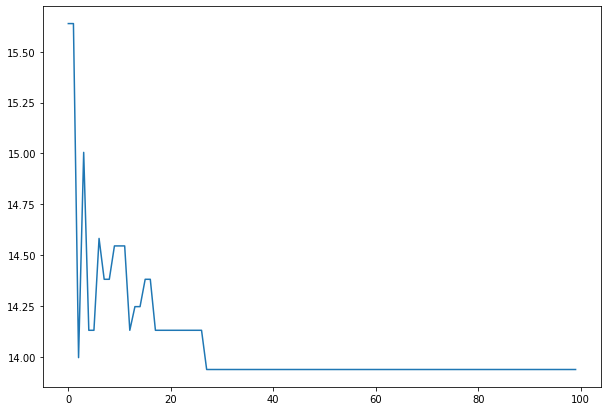

Solution:  [('car1', 3, 3), (8, 1, 1), (6, 1, 1), (1, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (4, 1, 1), (7, 1, 1)]
fitness: 13.938887987977612


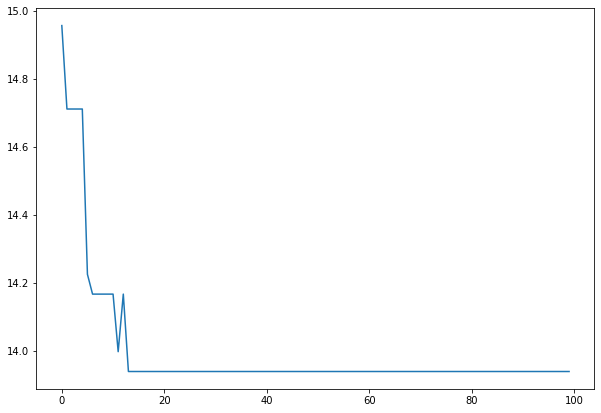

Solution:  [('car1', 3, 3), (7, 1, 1), (4, 1, 1), (1, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (6, 1, 1), (8, 1, 1)]
fitness: 14.007236703184981


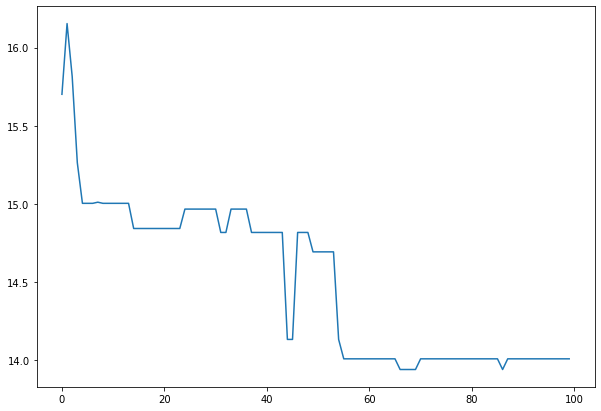

Solution:  [('car1', 3, 3), (1, 1, 1), (8, 1, 1), ('car3', 3, 3), (2, 1, 1), (5, 1, 1), (6, 1, 1), ('car2', 3, 3), (3, 1, 1), (7, 1, 1), (4, 1, 1)]
fitness: 14.545882090214963


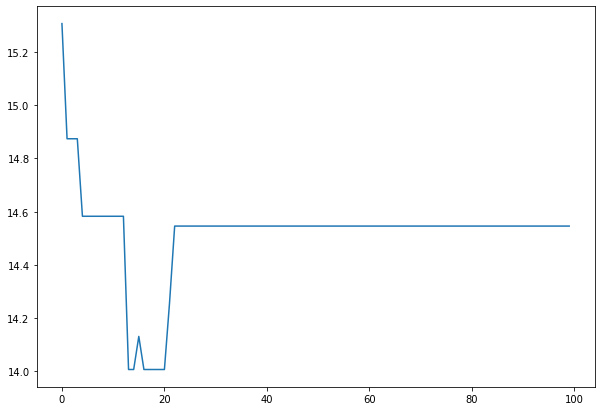



Total time:  33.67614412307739  secs.



In [2]:
"""

Vehicle Routing Problem
source code: https://github.com/fermenreq/TSP-VRP-GENETICS-ALGORITHM
author: José Luis González Chacón, Fernando Méndez Requena

modified by Heeyeon Kim

"""

def VRP(k):
    
    genes = [(int(x), 1, 1) for x in locations] # gene = (index of a location, volumn capa, location capa)
    org_chr = genes + cars_info[1:]
    VRP_PROBLEM = Problem_Genetic(org_chr, len(org_chr), lambda x: decodeVRP(x), lambda y: fitness_by_dist(y))
    
    def first_part_GA(k):
        cont  = 0

        print("Frontier = ",frontier)
        print("")
        tiempo_inicial_t2 = time()
        records = [] # record for result of each instance
        while cont <= k: 
            result = genetic_algorithm_t(VRP_PROBLEM, k=2, opt=min, ngen=100, size=100, ratio_cross=0.8, prob_mutate=0.1)
            records.append(result)
            cont+=1
        tiempo_final_t2 = time()
        print("\n") 
        print("Total time: ",(tiempo_final_t2 - tiempo_inicial_t2)," secs.\n")
        
        arg_min = np.argmin([records[i][1] for i in range(len(records))])
        best_sol = records[arg_min] # best solution among all records
        
        return best_sol
       
    return first_part_GA(k)
    print("------------------------------------------------------------------------------------------------------------------------------------------------------------------")
    
locations = [1,2,3,4,5,6,7,8]
capacity_car = 3
cars_info = [('car1', 3, 3), ('car2', 3, 3), ('car3', 3, 3)] # (차번호, volume capa, location capa)
num_cars = len(cars_info)
frontier = "---------"


spot_coord = {1: [37.517132, 127.018789],
 2: [37.490846, 127.030281],
 3: [37.485666, 127.029152],
 4: [37.490535, 127.005332],
 5: [37.492032, 127.029783],
 6: [37.495933, 127.028022],
 7: [37.480608, 126.998836],
 8: [37.49671, 127.0257],
 'center': [37.496104, 127.01939]}

if __name__ == "__main__":

    # Constant that is an instance object 
    genetic_problem_instances = 10
    print("EXECUTING ", genetic_problem_instances, " INSTANCES ")
    VRP(genetic_problem_instances)

We executed VRP 10 times to overcome a local minima problem. Whenever we execute VRP, we get the solution of VRP, a fitness score of the solution and a graph for fitness scores of best chromosome for each iteration. Among above 10 times experiments, the best solution (solution with the smallest fitness score) is:

Solution:  [('car1', 3, 3), (7, 1, 1), (4, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (1, 1, 1), (6, 1, 1), (8, 1, 1)]

with fitness score = 13.93888798797761. It implies the route that car1 visits location 7 and 4, car3 visits location 3, 2 and 5, and car2 visits location 1, 6, 8 with the total distance = 13.93888798797761 km. In fact, it is the optimal route suggested by genetic algorithm.

We can visualize the result using folium as follows.

In [4]:
import folium

solution =[('car1', 3, 3), (7, 1, 1), (4, 1, 1), ('car3', 3, 3), (3, 1, 1), (2, 1, 1), (5, 1, 1), ('car2', 3, 3), (1, 1, 1), (6, 1, 1), (8, 1, 1)]



m = folium.Map(location=spot_coord['center'], zoom_start=13)
points = []
for i in range(len(solution)):
    if type(solution[i][0]) != int:
        # add depot
        folium.Marker(spot_coord['center'], popup='Depot', icon=folium.Icon(color='purple')).add_to(m)
        points.append(spot_coord['center'])
    else:
        # add each location
        folium.CircleMarker(spot_coord[solution[i][0]], popup='Location {}'.format(solution[i][0]), 
                            radius=7, color='blue', fill_color='blue').add_to(m)
        points.append(spot_coord[solution[i][0]])
points.append(spot_coord['center'])
# add lines
folium.PolyLine(points, color="red", weight=2.5, opacity=1).add_to(m)

m